# Aridity 

### Description
Script for analysing Aridity Index (p/pet) from different sources (AWAP/AWRA, BARPA, CCAM, WRF, NHP1, etc). Values for classification according to https://wad.jrc.ec.europa.eu/patternsaridity#:~:text=The%20Aridity%20Index%20(AI)%20is,climate%20at%20a%20given%20location.
Other reference: https://www.painblogr.org/2020-12-15-climate-change.html 

In [1]:
#< import modules
import os
import xarray as xr
import numpy as np
# import cmdline_provenance as cmdprov
# import git
import sys
import dask.distributed
import glob
from dask.distributed import Client
import tempfile
import dask
from dask.diagnostics import ProgressBar
import lib_david
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs 
import cartopy.feature as cfeature

# Ignore specific warning by category
warnings.filterwarnings('ignore') 

In [2]:
# Dask settings
dask.config.set({
    #'array.chunk-size': "256 MiB",
    #'array.slicing.split_large_chunks': True, 
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #< This should use the new behaviour which helps with memory pile up
})

client = Client(n_workers=20, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "252000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 20
Total threads: 20,Total memory: 4.58 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35715,Workers: 20
Dashboard: /proxy/8787/status,Total threads: 20
Started: Just now,Total memory: 4.58 TiB
Comm: tcp://127.0.0.1:38277,Total threads: 1
Dashboard: /proxy/36797/status,Memory: 234.69 GiB
Nanny: tcp://127.0.0.1:45007,


In [4]:
# client.close()

## Read PET datasets and set parameters 

In [2]:
sYear = '1995'
eYear = '2014'
def _preprocess(ds):
    return ds.sel(time=slice(f'{sYear}-01-01',f'{eYear}-12-31'),
                  lat=slice(-44,-10),
                  lon=slice(110,154)).chunk({'time':-1,'lat':50,'lon':50})
def _preprocess_uq(ds):
    return ds.sel(time=slice(f'{sYear}-01-01',f'{eYear}-12-31'),
                  lat=slice(-44,-10),
                  lon=slice(112,154)).chunk({'time':-1,'lat':50,'lon':50})
def _preprocess_awra(ds):
    return ds.sel(time=slice(f'{sYear}-01-01',f'{eYear}-12-31'),
                  latitude=slice(-10,-44),
                  longitude=slice(110,154)).chunk({'time':-1,'latitude':50,'longitude':50})
def _preprocess_wrf(ds):
    return ds.sel(time=slice(f'{sYear}-01-01',f'{eYear}-12-31'))#).chunk({'time':-1,'latitude':50,'longitude':50})

agcd_mask = xr.open_dataset('/home/565/dh4185/mn51-dh4185/agcd_v1-0-2_precip_weight_r005_daily_1960_2022fraction_ge1.nc').fraction.sel(lat=slice(-44,-10),lon=slice(112,154))
ls_mask_agcd = np.ma.masked_greater(agcd_mask,0.8)

In [9]:
%%time
###< Read PET data 
# #< Reference: PM-PET from AWRA-L (obs proxy)
# awra_e0_mon = xr.open_mfdataset("/scratch/mn51/dh4185/e0_avg_*_monsum.nc",combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess_awra).e0.chunk({'time':-1,'latitude':100,'longitude':50}).rename({'longitude':'lon','latitude':'lat'})
# awra_e0_day = xr.open_mfdataset("/g/data/fj8/BoM/AWRA/DATA/v7/simulation/e0_*.nc",combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess_awra).e0.chunk({'time':-1,'latitude':100,'longitude':50}).rename({'longitude':'lon','latitude':'lat'})

# #< BARRA-R2
# evspsblpot_barra_day = xr.open_mfdataset('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/evspsblpot/latest/evspsblpot_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_*.nc',combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess).evspsblpot.chunk({'time':-1,'lat':60,'lon':60})* 86400

#< AWO 
# awo_penpet_day = xr.open_mfdataset('/g/data/iu04/australian-water-outlook/historical/v1/ET/pen_pet_*.nc',combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess_awra).pen_pet.chunk({'time':-1,'latitude':60,'longitude':60})
# awo_faopet_day = xr.open_mfdataset('/g/data/iu04/australian-water-outlook/historical/v1/ET/fao_pet_*.nc',combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess_awra).fao_pet.chunk({'time':-1,'latitude':60,'longitude':60})

# #< NHP1.0
# e0_nhp_day_hist = xr.open_dataset('/g/data/wj02/COMPLIANT_PUBLISHED/HMOUTPUT/output/AUS-5/BoM/AWRALv6-1-CSIRO-BOM-ACCESS1-0/historical/r1i1p1/r240x120-MRNBC-AWAP/latest/day/e0/AWRALv6-1-CSIRO-BOM-ACCESS1-0_r240x120-MRNBC-AWAP_historical_r1i1p1_e0_AUS-5_day_v1_19600101-20051231.nc').sel(time=slice(sYear,'2005'),lat=slice(-44,-10),lon=slice(112,154)).chunk({'time':-1,'lat':80,'lon':80}).e0
# e0_nhp_day_proj = xr.open_dataset('/g/data/wj02/COMPLIANT_PUBLISHED/HMOUTPUT/output/AUS-5/BoM/AWRALv6-1-CSIRO-BOM-ACCESS1-0/rcp85/r1i1p1/r240x120-MRNBC-AWAP/latest/day/e0/AWRALv6-1-CSIRO-BOM-ACCESS1-0_r240x120-MRNBC-AWAP_rcp85_r1i1p1_e0_AUS-5_day_v1_20060101-20991231.nc').sel(time=slice('2006',eYear),lat=slice(-44,-10),lon=slice(112,154)).chunk({'time':-1,'lat':80,'lon':80}).e0
# e0_nhp_day = xr.concat([e0_nhp_day_hist, e0_nhp_day_proj], dim="time")

# # #< Raw and adjusted (AWO SSP3-7.0) FAO PMPET from UQ-DES CCAM ACCESS-ESM1.5
# uqdes_sftlf = xr.open_dataset('/g/data/ig45/QldFCP-2/output/CMIP6/DD/AUS-10i/UQ-DEC/ACCESS-ESM1-5/historical/r6i1p1f1/CCAM-v2105/v1-r1/fx/sftlf/latest/sftlf_AUS-10i_ACCESS-ESM1-5_historical_r6i1p1f1_UQ-DEC_CCAM-v2105_v1-r1.nc').sel(lat=slice(-44,-10),lon=slice(112,154)).sftlf
# ls_mask_uqdes = np.ma.masked_greater(uqdes_sftlf,90)
# uqdes_FAO_day = xr.open_dataset('/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/fao_pet_UQDES/FAO_ACCESS-ESM1-5_ssp370_r6i1p1f1_CCAM10_aus-10i_10km_day_198101-210012.nc').FAO.sel(time=slice(sYear,eYear),lat=slice(-44,-10),lon=slice(112,154)).chunk({'time':-1,'lat':80,'lon':80})
# uqdes_FAO_bc_day = xr.open_dataset('/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/fao_pet_UQDES/FAO_QDMcmonthly_ACCESS-ESM1-5_CCAM10_198101-202012.nc').FAO.sel(time=slice(sYear,eYear),lat=slice(-44,-10),lon=slice(112,154)).chunk({'time':-1,'lat':80,'lon':80})

#< FAO PM-PET calculated from raw BOM-BARPA ACCESS-ESM1.5 output
barpa_sftlf = xr.open_dataset('/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-ESM1-5/historical/r6i1p1f1/BARPA-R/v1-r1/fx/sftlf/latest/sftlf_AUS-15_ACCESS-ESM1-5_historical_r6i1p1f1_BOM_BARPA-R_v1-r1_fx.nc').sel(lat=slice(-44,-10),lon=slice(110,154)).sftlf
ls_mask_barpa = np.ma.masked_greater(barpa_sftlf,0.9)
fao_barpa_day = xr.open_mfdataset('/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/pet_fao/PET_FAO_AUS-15_ACCESS-ESM1-5_historical_r6i1p1f1_BOM_BARPA-R_v1-r1_day_*.nc',combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess).chunk({'time':-1,'lat':80,'lon':80})
# etrs_barpa_day = fao_barpa_day.ETrs
etos_barpa_day = fao_barpa_day.ETos

# #< FAO PM-PET calculated from raw WRF ACCESS-ESM1.5 output
# wrf_sftlf = xr.open_dataset('/g/data/zz63/NARCliM2-0/output/CMIP6/DD/AUS-18/NSW-Government/ACCESS-ESM1-5/historical/r6i1p1f1/NARCliM2-0-WRF412R3/v1-r1/fx/sftlf/latest/sftlf_AUS-18_ACCESS-ESM1-5_historical_r6i1p1f1_NSW-Government_NARCliM2-0-WRF412R3_v1-r1_fx.nc').sftlf#.drop(['lat','lon']).rename({'rlat':'lat','rlon':'lon'})
# ls_mask_wrf = np.ma.masked_greater(wrf_sftlf,90)
# fao_wrf_day = xr.open_mfdataset('/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/pet_fao/PET_FAO_AUS-18_ACCESS-ESM1-5_historical_r6i1p1f1_NSW-Government_NARCliM2-0-WRF412R3_v1-r1_day_*.nc',combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess_wrf).chunk({'time':-1,'rlat':80,'rlon':80})
# # etrs_wrf_day = fao_wrf_day.ETrs
# etos_wrf_day = fao_wrf_day.ETos

# #< Raw direct PET model output from BOM-BARPA for ACCESS-ESM1.5
# evspsblpot_barpa_day = xr.open_mfdataset('/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-ESM1-5/historical/r6i1p1f1/BARPA-R/v1-r1/day/evspsblpot/latest/evspsblpot_AUS-15_ACCESS-ESM1-5_historical_r6i1p1f1_BOM_BARPA-R_v1-r1_day_*.nc' ,combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess).evspsblpot.chunk({'time':-1,'lat':80,'lon':80})* 86400

# #< Raw direct PET model output from CSIRO-CCAM for ACCESS-ESM1.5
# csiro_ccam_sftlf = xr.open_dataset('/g/data/hq89/CCAM/output/CMIP6/DD/AUS-10i/CSIRO/ACCESS-ESM1-5/historical/r6i1p1f1/CCAM-v2203-SN/v1-r1/fx/sftlf/v20231206/sftlf_AUS-10i_ACCESS-ESM1-5_historical_r6i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1.nc').sel(lat=slice(-44,-10),lon=slice(110,154)).sftlf
# ls_mask_csiro_ccam = np.ma.masked_greater(csiro_ccam_sftlf,90)
# evspsblpot_csiro_ccam_day = xr.open_mfdataset('/g/data/hq89/CCAM/output/CMIP6/DD/AUS-10i/CSIRO/ACCESS-ESM1-5/historical/r6i1p1f1/CCAM-v2203-SN/v1-r1/day/evspsblpot/v20231206/evspsblpot_AUS-10i_ACCESS-ESM1-5_historical_r6i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1_day_*.nc' ,combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess).evspsblpot.chunk({'time':-1,'lat':80,'lon':80})* 86400

# #< FAO PM-PET calculated from raw CSIRO-CCAM ACCESS-ESM1.5 output
# fao_csiro_ccam_day = xr.open_mfdataset('/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/pet_fao/PET_FAO_AUS-10i_ACCESS-ESM1-5_historical_r6i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1_day*.nc',combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess).chunk({'time':-1,'lat':80,'lon':80})
# # etrs_csiro_ccam_day = fao_csiro_ccam_day.ETrs
# etos_csiro_ccam_day = fao_csiro_ccam_day.ETos

# HARGRAVES PET
barpa_sftlf = xr.open_dataset('/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-ESM1-5/historical/r6i1p1f1/BARPA-R/v1-r1/fx/sftlf/latest/sftlf_AUS-15_ACCESS-ESM1-5_historical_r6i1p1f1_BOM_BARPA-R_v1-r1_fx.nc').sel(lat=slice(-44,-10),lon=slice(110,154)).sftlf
ls_mask_barpa = np.ma.masked_greater(barpa_sftlf,0.9)
harg_barpa_day = xr.open_mfdataset('/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/pet_Hargraves/PET_Hargraves_AUS-15_ACCESS-ESM1-5_historical_r6i1p1f1_BOM_BARPA-R_v1-r1_day_*.nc',combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess).chunk({'time':-1,'lat':80,'lon':80}).pet_hargraves



CPU times: user 2 s, sys: 867 ms, total: 2.87 s
Wall time: 2.1 s


In [10]:
barpa_harg = harg_barpa_day.mean('time').compute()
barpa_fao = etos_barpa_day.mean('time').compute()
pet = xr.concat([barpa_harg,barpa_fao], dim=xr.DataArray(["BARPA-ACCESSESM1.5 FAO56", "BARPA-ACCESSESM1.5 Hargraves"], dims="method"))


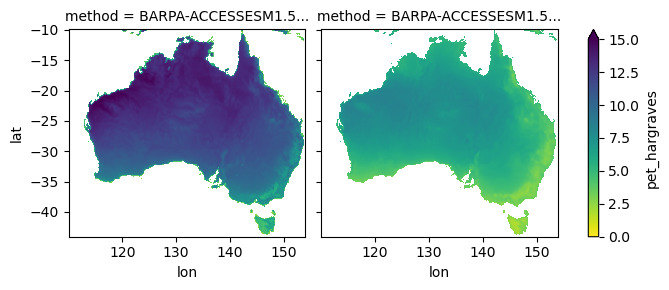

In [12]:
pet.where(ls_mask_barpa.mask).plot(col="method", cmap="viridis_r",vmin=0, vmax=15)

In [5]:
%%time
awo_fao = awo_faopet_day.mean('time').compute()
awo_pen = awo_penpet_day.mean('time').compute()
awra_e0 = awra_e0_day.mean('time').rename({'lat':'latitude','lon':'longitude'}).compute()
pet = xr.concat([awo_fao,awo_pen,awra_e0], dim=xr.DataArray(["awo_fao", "awo_pen", "awra_e0"], dims="method"))

CPU times: user 14min 17s, sys: 36.4 s, total: 14min 53s
Wall time: 14min 55s


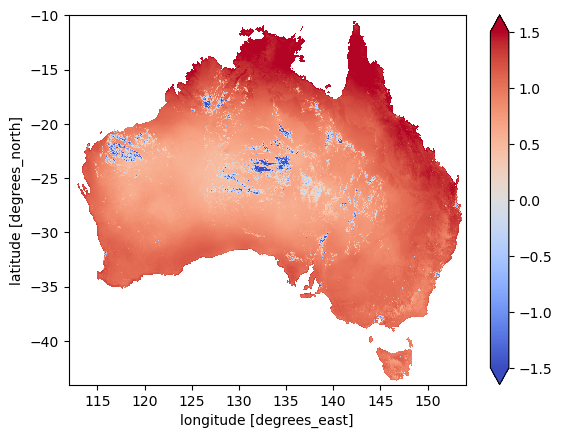

In [20]:
(awra_e0-awo_fao).plot(cmap="coolwarm",vmin=-1.5,vmax=1.5)#, title="diff (awra_e0 - awo_fao)")


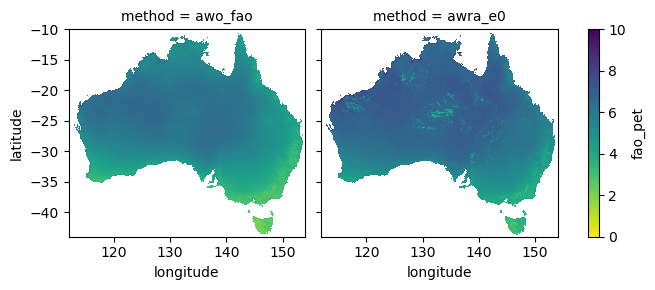

In [18]:
pet = xr.concat([awo_fao,awra_e0], dim=xr.DataArray(["awo_fao", "awra_e0"], dims="method"))
pet.plot(col="method", cmap="viridis_r",vmin=0, vmax=10)

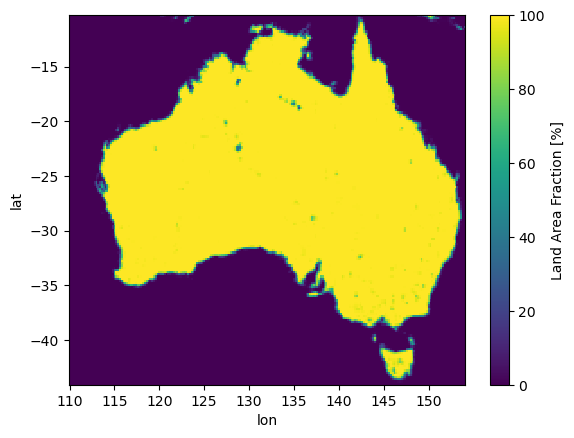

In [7]:
###< Regridding for WRF data
import xesmf as xe
# Specify output grid
lat_out_1d = np.arange(-44,-10.2,0.2)
lon_out_1d = np.arange(110,154.2,0.2)

lat_out_2d,lon_out_2d = np.meshgrid(lat_out_1d, lon_out_1d)

grid_out  = xr.Dataset(coords={
        'lon':lon_out_1d,
        'lat':lat_out_1d,
        'longitude': (['lon','lat'],lon_out_2d),
        'latitude': (['lon','lat'],lat_out_2d)
        }
    )

# Use regridder -> can save the weights as a file to reuse them more easily (takes some time to calculate them each time)
regridder = xe.Regridder(wrf_sftlf, grid_out, method='bilinear', reuse_weights=False)

regridder._grid_in  = None # Otherwise there is trouble with dask
regridder._grid_out = None # Otherwise there is trouble with dask

ds_regid = regridder(wrf_sftlf,keep_attrs=True)
ds_regid.drop(['latitude','longitude']).plot()

In [5]:
###< Process PET data 
%%time

pet_list = [awra_e0_day,
            e0_nhp_day,
            uqdes_FAO_bc_day,
            uqdes_FAO_day,        
            etos_barpa_day,
            etos_csiro_ccam_day,
            etos_wrf_day,
            evspsblpot_barpa_day,
            evspsblpot_csiro_ccam_day]
pet_list_names=['AWRA-L','NHP1.0','UQ-DES FAO-PM (adjusted)','UQ-DES FAO-PM',
                'BARPA FAO-PM','CSIRO-CCAM FAO-PM','WRF FAO-PM','evspsblpot BOM-BARPA','evspsblpot CSIRO-CCAM']

pet_list_2D=[]
for i,item in enumerate(pet_list):

    print(f'############### {pet_list_names[i]} ###############')
    d = item.mean('time').compute()#.groupby('time.year').sum('time').mean('year').compute()
    
    if pet_list_names[i] in ['UQ-DES FAO-PM','UQ-DES FAO-PM (adjusted)']:
        print(f'masking {pet_list_names[i]}')
        pet_list_2D.append(d.where(ls_mask_uqdes.mask))
    elif pet_list_names[i] in ['BARPA ASCE-PM','BARPA FAO-PM','evspsblpot BOM-BARPA']:
        pet_list_2D.append(d.where(ls_mask_barpa.mask))
        print(f'masking {pet_list_names[i]}')
    elif pet_list_names[i] in ['WRF FAO-PM','WRF ASCE-PM']:
        # d_regrid = regridder(d.where(ls_mask_wrf.mask),keep_attrs=True).drop(['latitude','longitude'])
        pet_list_2D.append(d.where(ls_mask_wrf.mask))#_regrid)
        print(f'masking {pet_list_names[i]}')
    elif pet_list_names[i] in ['evspsblpot CSIRO-CCAM','CSIRO-CCAM FAO-PM']:
        pet_list_2D.append(d.where(ls_mask_csiro_ccam.mask))
        print(f'masking {pet_list_names[i]}')
    else:
        pet_list_2D.append(d)

# pet_list_2D

############### AWRA-L ###############
############### NHP1.0 ###############
############### UQ-DES FAO-PM (adjusted) ###############
masking UQ-DES FAO-PM (adjusted)
############### UQ-DES FAO-PM ###############
masking UQ-DES FAO-PM
############### BARPA FAO-PM ###############
masking BARPA FAO-PM
############### CSIRO-CCAM FAO-PM ###############
masking CSIRO-CCAM FAO-PM
############### WRF FAO-PM ###############
masking WRF FAO-PM
############### evspsblpot BOM-BARPA ###############
masking evspsblpot BOM-BARPA
############### evspsblpot CSIRO-CCAM ###############
masking evspsblpot CSIRO-CCAM
CPU times: user 13min 39s, sys: 49.1 s, total: 14min 28s
Wall time: 17min 43s


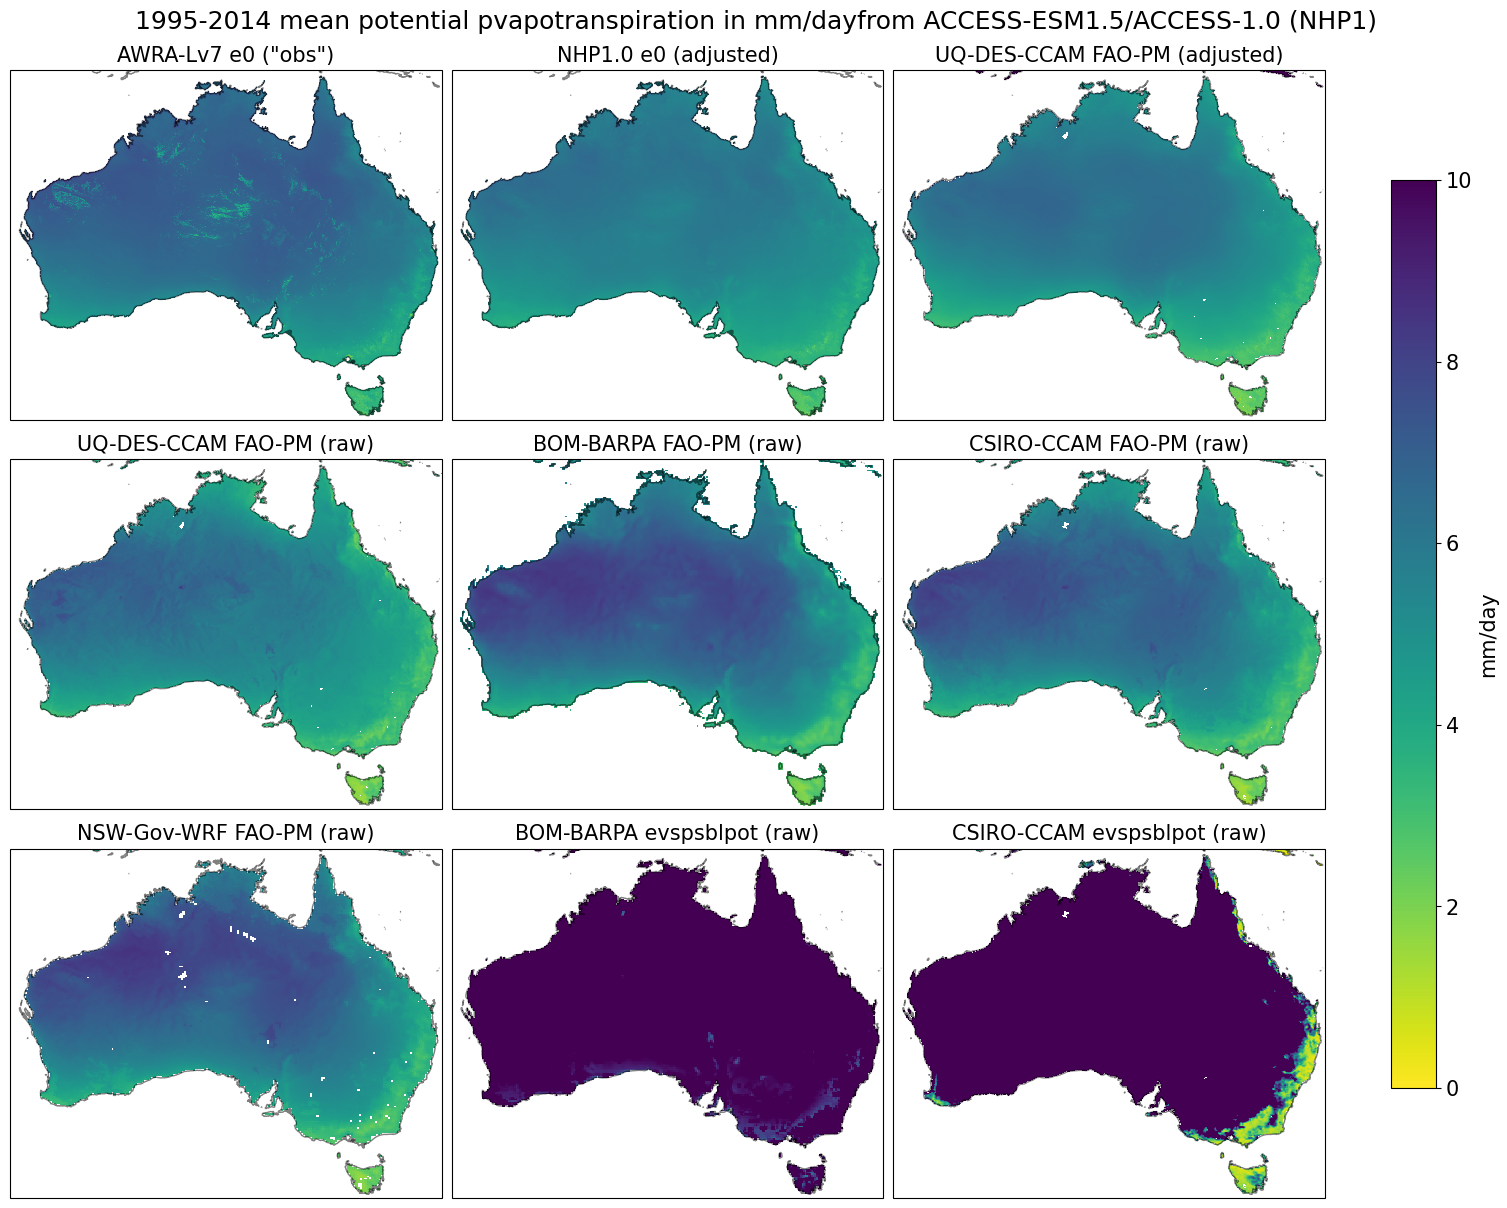

In [6]:
###< Facet plot for PET comparison
plot_names=['AWRA-Lv7 e0 ("obs")','NHP1.0 e0 (adjusted)','UQ-DES-CCAM FAO-PM (adjusted)','UQ-DES-CCAM FAO-PM (raw)',
                'BOM-BARPA FAO-PM (raw)','CSIRO-CCAM FAO-PM (raw)','NSW-Gov-WRF FAO-PM (raw)','BOM-BARPA evspsblpot (raw)','CSIRO-CCAM evspsblpot (raw)']

# Determine common color scale
vmin = 0  # Min value for color scale
vmax = 10  # Max value for color scale

# Set up subplot grid: calculate rows and columns
n = len(pet_list_2D)
ncols = 3  # Fixed number of columns
nrows = -(-n // ncols)  # Compute rows (ceil division)

# set areal limit for plotting
x_limits = (112,154)
y_limits = (-44, -10)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(5 * ncols, 4 * nrows),
    subplot_kw={"projection": ccrs.PlateCarree()},  # Set projection
    constrained_layout=True
)

# Flatten axes to handle grid indexing
axes = axes.flat if n > 1 else [axes]

# Plot each DataArray
for i, (da, ax) in enumerate(zip(pet_list_2D, axes)):
    im = ax.pcolormesh(
        da.lon,
        da.lat,
        da,
        cmap="viridis_r",  # Choose your colormap
        vmin=vmin,
        vmax=vmax,
        transform=ccrs.PlateCarree(),  # Transform data to PlateCarree
    )
    # Add geographic features
    # ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_extent([x_limits[0], x_limits[1], y_limits[0], y_limits[1]], crs=ccrs.PlateCarree())
    # im = da.plot(
    #     ax=ax,
    #     cmap="viridis",  # Choose your colormap
    #     vmin=vmin,
    #     vmax=vmax,
    #     add_colorbar=False,
    # )
    # ax.set_xlim(x_limits)
    # ax.set_ylim(y_limits)
    ax.set_title(plot_names[i], fontsize=15)
    ax.coastlines(resolution = '10m', alpha = 0.5)

# Remove any empty subplots
for j, ax in enumerate(axes[len(pet_list_2D):]):
    ax.axis("off")

# Add a single shared colorbar
cbar= fig.colorbar(im, ax=axes[:n], orientation="vertical", shrink=0.8, label="mm/day")  # Adjust label as needed
cbar.ax.tick_params(labelsize=15)  # Set tick label font size (e.g., 10)
cbar.set_label("mm/day", fontsize=15)

fig.suptitle("1995-2014 mean potential pvapotranspiration in mm/dayfrom ACCESS-ESM1.5/ACCESS-1.0 (NHP1)", fontsize=18)
fig.savefig('/g/data/mn51/users/dh4185/pet_comparison.png',dpi=300, bbox_inches="tight")
plt.show()


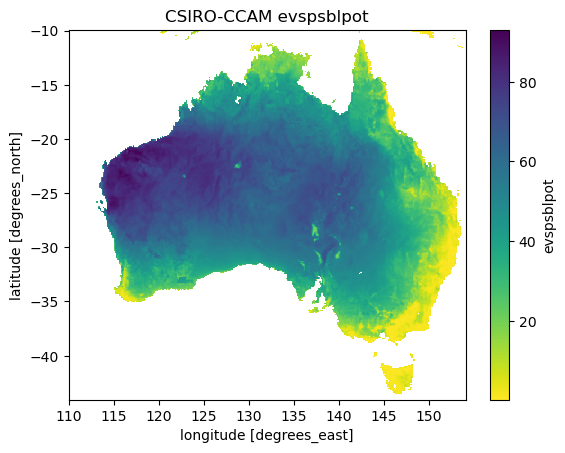

In [8]:
###< Plot for CCAM with adjusted scale
pet_list_2D[-1].plot(cmap="viridis_r")
plt.title('CSIRO-CCAM evspsblpot')
# Save the figure to a file
plt.savefig('/g/data/mn51/users/dh4185/CSIRO_CCAM_evspsblpot_plot.png', dpi=300, bbox_inches="tight")

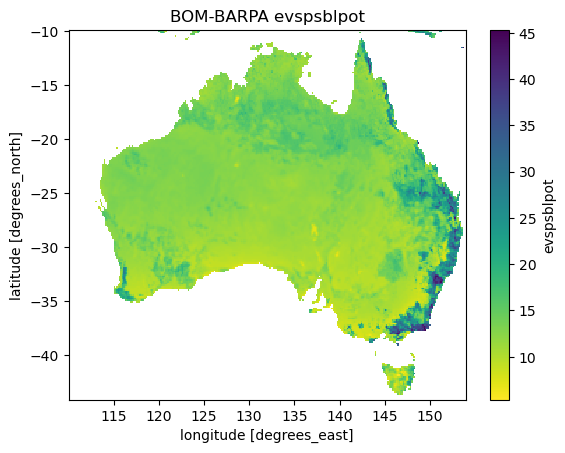

In [9]:
###< Plot for BARPA with adjusted scale
pet_list_2D[-2].plot(cmap="viridis_r")
plt.title('BOM-BARPA evspsblpot')
plt.savefig('/g/data/mn51/users/dh4185/BOM-BARPA_evspsblpot_plot.png', dpi=300, bbox_inches="tight")

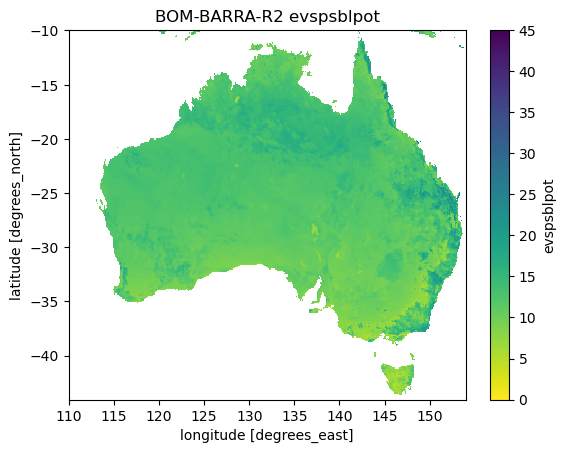

In [7]:
###< Plot for BARRA-R2 with adjusted scale
evspsblpot_barra_day.mean('time').plot(cmap="viridis_r",vmin=0, vmax=45)
plt.title('BOM-BARRA-R2 evspsblpot')
plt.savefig('/g/data/mn51/users/dh4185/BOM-BARRA-R2_evspsblpot_plot.png', dpi=300, bbox_inches="tight")

In [6]:
###< Plotting with month (experimental)
# %%time
# pet_list_3D = pet_list_2D
# # Determine common color scale
# vmin = 0  # Min value for color scale
# vmax = 40  # Max value for color scale

# # Define number of rows and columns
# months = 12  # Fixed: Jan to Dec
# ncols = len(pet_list_3D)  # One column per dataset
# nrows = months  # One row per month

# fig, axes = plt.subplots(
#     nrows=nrows,
#     ncols=ncols,
#     figsize=(5 * ncols, 3 * nrows),  # Adjust size for clarity
#     constrained_layout=True
# )

# # Flatten axes for easier indexing (always a 2D grid in this case)
# axes = axes.reshape(nrows, ncols)  # Preserve rows and columns structure

# # Plot each DataArray
# for col, (da, name) in enumerate(zip(pet_list_3D, pet_list_names)):
#     for row in range(months):
#         ax = axes[row, col]
#         da.sel(month=row + 1).plot(
#             ax=ax,
#             cmap="viridis",  # Choose your colormap
#             vmin=vmin,
#             vmax=vmax,
#             add_colorbar=False,
#         )
#         # Add titles and labels
#         if row == 0:  # Top row: Dataset name
#             ax.set_title(name)
#         if col == 0:  # Leftmost column: Month label
#             ax.set_ylabel(["Jan", "Feb", "Mar", "Apr", "May", "Jun",
#                            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"][row])

# # Remove empty spaces if any
# for ax in axes.flat:
#     if not ax.has_data():
#         ax.axis("off")

# # Add a shared colorbar
# cbar = fig.colorbar(im, ax=axes, orientation="vertical", shrink=0.8, label="mm/day")  # Adjust label as needed
# # set areal limit for plotting
# plt.xlim((110,154))
# plt.ylim((-44, -10))
# plt.show()


## Read precipitation data

In [43]:
%%time
###< Read precipitation data 
#< Reference: AGCD v1.0.2 (daily totals) and v2.0.2 (monthly totals)
agcd_pr_mon = xr.open_mfdataset("/g/data/zv2/agcd/v2-0-2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_*.nc",combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess).precip.chunk({'time':-1,'lat':100,'lon':50})#.rename({'longitude':'lon','latitude':'lat'})
agcd_pr_day = xr.open_mfdataset("/g/data/zv2/agcd/v1-0-2/precip/total/r005/01day/agcd_v1_precip_total_r005_daily_*.nc",combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess).precip.chunk({'time':-1,'lat':100,'lon':50})#.rename({'longitude':'lon','latitude':'lat'})

#< BARRA-R2
barra_sftlf = xr.open_dataset('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/fx/sftlf/latest/sftlf_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1.nc').sel(lat=slice(-44,-10),lon=slice(110,154)).sftlf
ls_mask_barra = np.ma.masked_greater(barra_sftlf,90)
pr_barra_day = xr.open_mfdataset('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/pr/latest/pr_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_*.nc',combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess).pr.chunk({'time':-1,'lat':60,'lon':60})* 86400

#< NHP1.0
pr_nhp_day_hist = xr.open_dataset('/g/data/wj02/COMPLIANT_PUBLISHED/HMINPUT/output/AUS-5/BoM/CSIRO-BOM-ACCESS1-0/historical/r1i1p1/r240x120-MRNBC-AWAP/latest/day/pr/pr_AUS-5_CSIRO-BOM-ACCESS1-0_historical_r1i1p1_r240x120-MRNBC-AWAP_v1_day_19600101-20051231.nc').sel(time=slice(sYear,'2005'),lat=slice(-44,-10),lon=slice(112,154)).chunk({'time':-1,'lat':80,'lon':80}).pr * 86400
pr_nhp_day_proj = xr.open_dataset('/g/data/wj02/COMPLIANT_PUBLISHED/HMINPUT/output/AUS-5/BoM/CSIRO-BOM-ACCESS1-0/rcp85/r1i1p1/r240x120-MRNBC-AWAP/latest/day/pr/pr_AUS-5_CSIRO-BOM-ACCESS1-0_rcp85_r1i1p1_r240x120-MRNBC-AWAP_v1_day_20060101-20991231.nc').sel(time=slice('2006',eYear),lat=slice(-44,-10),lon=slice(112,154)).chunk({'time':-1,'lat':80,'lon':80}).pr * 86400
pr_nhp_day = xr.concat([pr_nhp_day_hist, pr_nhp_day_proj], dim="time")

#< Raw and adjusted UQ-DES CCAM ACCESS-ESM1.5
pr_uqdes_FAO_day = xr.open_mfdataset('/g/data/ig45/QldFCP-2/output/CMIP6/DD/AUS-10i/UQ-DEC/ACCESS-ESM1-5/historical/r6i1p1f1/CCAM-v2105/v1-r1/day/pr/latest/pr_AUS-10i_ACCESS-ESM1-5_historical_r6i1p1f1_UQ-DEC_CCAM-v2105_v1-r1_day_*.nc',combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess_uq).pr.chunk({'time':-1,'lat':80,'lon':80})* 86400
pr_uqdes_FAO_bc_day = xr.open_mfdataset('/g/data/ia39/australian-climate-service/release/CORDEX/output-Adjust/CMIP6/bias-adjusted-output/AUST-05i/UQ-DES/ACCESS-ESM1-5/historical/r6i1p1f1/CCAM-v2105/v1-r1-ACS-MRNBC-AGCDv1-1960-2022/day/prAdjust/v20241216/prAdjust_AUST-05i_ACCESS-ESM1-5_historical_r6i1p1f1_UQ-DES_CCAM-v2105_v1-r1-ACS-MRNBC-AGCDv1-1960-2022_day_*.nc',combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess_uq).prAdjust.chunk({'time':-1,'lat':80,'lon':80})

#< Raw BOM-BARPA ACCESS-ESM1.5 output
pr_barpa_day = xr.open_mfdataset('/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-ESM1-5/historical/r6i1p1f1/BARPA-R/v1-r1/day/pr/latest/pr_AUS-15_ACCESS-ESM1-5_historical_r6i1p1f1_BOM_BARPA-R_v1-r1_day_*.nc',combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess).chunk({'time':-1,'lat':80,'lon':80}).pr* 86400

#< Raw WRF ACCESS-ESM1.5 output
# wrf_sftlf = xr.open_dataset('/g/data/zz63/NARCliM2-0/output/CMIP6/DD/AUS-18/NSW-Government/ACCESS-ESM1-5/historical/r6i1p1f1/NARCliM2-0-WRF412R3/v1-r1/fx/sftlf/latest/sftlf_AUS-18_ACCESS-ESM1-5_historical_r6i1p1f1_NSW-Government_NARCliM2-0-WRF412R3_v1-r1_fx.nc').sftlf#.drop(['lat','lon']).rename({'rlat':'lat','rlon':'lon'})
# ls_mask_wrf = np.ma.masked_greater(wrf_sftlf,90)
pr_wrf_day = xr.open_mfdataset('/g/data/zz63/NARCliM2-0/output/CMIP6/DD/AUS-18/NSW-Government/ACCESS-ESM1-5/historical/r6i1p1f1/NARCliM2-0-WRF412R3/v1-r1/day/pr/latest/pr_AUS-18_ACCESS-ESM1-5_historical_r6i1p1f1_NSW-Government_NARCliM2-0-WRF412R3_v1-r1_day_*.nc',combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess_wrf).chunk({'time':-1,'rlat':80,'rlon':80}).pr * 86400

#< Raw CSIRO-CCAM ACCESS-ESM1.5 output
pr_csiro_ccam_day = xr.open_mfdataset('/g/data/hq89/CCAM/output/CMIP6/DD/AUS-10i/CSIRO/ACCESS-ESM1-5/historical/r6i1p1f1/CCAM-v2203-SN/v1-r1/day/pr/v20231206/pr_AUS-10i_ACCESS-ESM1-5_historical_r6i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1_day_*.nc',combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess).chunk({'time':-1,'lat':80,'lon':80}).pr* 86400



CPU times: user 28.3 s, sys: 4.34 s, total: 32.7 s
Wall time: 34.4 s


In [ ]:
%%time
###< Process PET data 
pet_list = [agcd_pr_day,
            pr_nhp_day,
            pr_uqdes_FAO_bc_day,
            pr_uqdes_FAO_day,
            pr_barra_day,        
            pr_barpa_day,
            pr_wrf_day,
            pr_csiro_ccam_day]
pet_list_names = ['AGCD v1.0.2','NHP1.0','UQ-DES (adjusted)','UQ-DES','BARRA-R2',
                  'BARPA','WRF NSW-Gov','CSIRO-CCAM']

pet_list_2D=[]
for i,item in enumerate(pet_list):

    print(f'############### {pet_list_names[i]} ###############')
    d = item.mean('time').compute()#.groupby('time.year').sum('time').mean('year').compute()
    
    if pet_list_names[i] in ['WRF NSW-Gov']:
        # d_regrid = regridder(d.where(ls_mask_wrf.mask),keep_attrs=True).drop(['latitude','longitude'])
        pet_list_2D.append(d.where(ls_mask_wrf.mask))#_regrid)
        print(f'masking {pet_list_names[i]}')
    elif pet_list_names[i] in ['CSIRO-CCAM']:
        pet_list_2D.append(d.where(ls_mask_csiro_ccam.mask))
        print(f'masking {pet_list_names[i]}')
    elif pet_list_names[i] in ['BARPA']:
        pet_list_2D.append(d.where(ls_mask_barpa.mask))
        print(f'masking {pet_list_names[i]}')
    elif pet_list_names[i] in ['BARRA-R2']:
        pet_list_2D.append(d.where(ls_mask_barra.mask))
        print(f'masking {pet_list_names[i]}')
    elif pet_list_names[i] in ['UQ-DES']:
        print(f'masking {pet_list_names[i]}')
        pet_list_2D.append(d.where(ls_mask_uqdes.mask))
    elif pet_list_names[i] in ['UQ-DES (adjusted)']:
        print(f'masking {pet_list_names[i]}')
        pet_list_2D.append(d.where(ls_mask_agcd.mask))
    else:
        pet_list_2D.append(d)

# pet_list_2D

############### AGCD v1.0.2 ###############
############### NHP1.0 ###############
############### UQ-DES (adjusted) ###############


In [ ]:
###< Facet plot for precipitation comparison
plot_names=pet_list_names#['AWRA-Lv7 e0 ("obs")','NHP1.0 e0 (adjusted)','UQ-DES-CCAM FAO-PM (adjusted)','UQ-DES-CCAM FAO-PM (raw)',
                # 'BOM-BARPA FAO-PM (raw)','CSIRO-CCAM FAO-PM (raw)','NSW-Gov-WRF FAO-PM (raw)','BOM-BARPA evspsblpot (raw)','CSIRO-CCAM evspsblpot (raw)']

# Determine common color scale
vmin = 0  # Min value for color scale
vmax = 10  # Max value for color scale

# Set up subplot grid: calculate rows and columns
n = len(pet_list_2D)
ncols = 3  # Fixed number of columns
nrows = -(-n // ncols)  # Compute rows (ceil division)

# set areal limit for plotting
x_limits = (112,154)
y_limits = (-44, -10)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(5 * ncols, 4 * nrows),
    subplot_kw={"projection": ccrs.PlateCarree()},  # Set projection
    constrained_layout=True
)

# Flatten axes to handle grid indexing
axes = axes.flat if n > 1 else [axes]

# Plot each DataArray
for i, (da, ax) in enumerate(zip(pet_list_2D, axes)):
    im = ax.pcolormesh(
        da.lon,
        da.lat,
        da,
        cmap="cividis_r",  # Choose your colormap
        vmin=vmin,
        vmax=vmax,
        transform=ccrs.PlateCarree(),  # Transform data to PlateCarree
    )
    # Add geographic features
    # ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_extent([x_limits[0], x_limits[1], y_limits[0], y_limits[1]], crs=ccrs.PlateCarree())
    # im = da.plot(
    #     ax=ax,
    #     cmap="viridis",  # Choose your colormap
    #     vmin=vmin,
    #     vmax=vmax,
    #     add_colorbar=False,
    # )
    # ax.set_xlim(x_limits)
    # ax.set_ylim(y_limits)
    ax.set_title(plot_names[i], fontsize=15)
    ax.coastlines(resolution = '10m', alpha = 0.5)

# Remove any empty subplots
for j, ax in enumerate(axes[len(pet_list_2D):]):
    ax.axis("off")

# Add a single shared colorbar
cbar= fig.colorbar(im, ax=axes[:n], orientation="vertical", shrink=0.8, label="mm/day")  # Adjust label as needed
cbar.ax.tick_params(labelsize=15)  # Set tick label font size (e.g., 10)
cbar.set_label("mm/day", fontsize=15)

fig.suptitle("1995-2014 mean daily precipitation in mm/day from AGCD/ACCESS-ESM1.5/ACCESS-1.0 (NHP1)", fontsize=18)
fig.savefig('/g/data/mn51/users/dh4185/pr_comparison.png',dpi=300, bbox_inches="tight")
plt.show()
